In [1]:
import numpy as np 
from utils import read_dataset, drop_useless
import os 

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
SUBJECT = "Finn"

dataset = read_dataset(SUBJECT,
                       # timestamp="10-12-24",
                       read_ort=False)
for nd in dataset:
    nd.fill(1.0)
dataset = drop_useless(dataset)
for nd in dataset: 
    nd.moving_average_filter(30, on="emg")
    nd.moving_average_filter(10, on="joints")

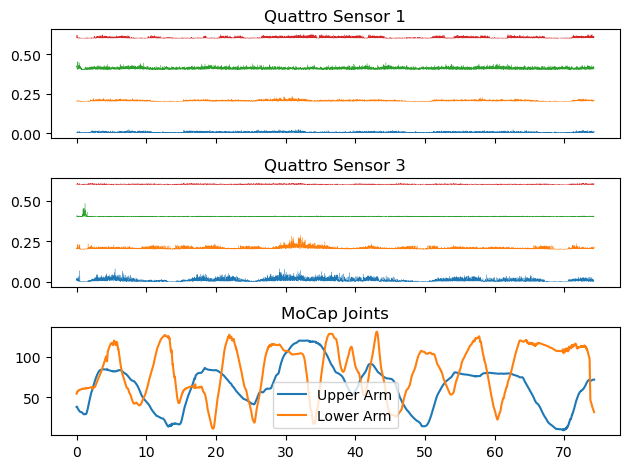

In [3]:
dataset[0].plot(plot_emg=True, plot_mocap_joints=True)

In [4]:
from numpy.lib.stride_tricks import sliding_window_view

def prepare_data_narx(n: int, data, lstm_ready: bool=True): 
    joints = data[0][:, -1, :]
    past = sliding_window_view(joints, (n, 2))
    if lstm_ready: 
        past = past.reshape(-1, n, 2)
    else: 
        past = past.reshape(-1, n*2)
    return data[-1][n:], joints[n:], past[:-1]

In [5]:
# prepare data: windowed emg data [..., 222, 8]: 222 Samples per win ~ 0.1sec = 100msec, 8 channels
# corresponding target: joint data [..., 2]: 2 joints Flexion/Extension and Pronation/Supination
# past joints: n - past joints (for narx) [..., 8]: 4 (n past samples) * 2 joints = 8 
# targets is 50 ms ahead of everything else

n_win = 10
emg_data, joints, past_joints = zip(*[prepare_data_narx(4, d.get_data(n_win, n_win, 222, n_win/2)) for d in dataset])

In [6]:
# norm emg: cumbersome, but needed to keep the chronical order
emg_max, emg_min = max(ed.max() for ed in emg_data), min(ed.min() for ed in emg_data)
emg_data = [(ed - emg_min) / (emg_max - emg_min) for ed in emg_data]
emg_max, emg_min

(1.3130887, 2.4274932e-05)

In [7]:
# norm joints 
joints_max, joints_min = max(x.max() for x in past_joints), min(x.min() for x in past_joints)
joints = [(jd - joints_min) / (joints_max - joints_min) for jd in joints]
past_joints = [(pj - joints_min) / (joints_max - joints_min) for pj in past_joints]
joints_max, joints_min

(157.01103, -28.994228)

In [8]:
total_windows = sum(ed.shape[0] for ed in emg_data)
train_data, val_data, test_data = [], [], []
cur_win = 0
for data in zip(emg_data, joints, past_joints): 
    cur_win += data[0].shape[0]
    if cur_win < total_windows * 0.15:
        test_data.append(data)
    elif cur_win > total_windows * 0.15 and cur_win <= total_windows * 0.3: 
        val_data.append(data)
    else: 
        train_data.append(data)

len(train_data), len(val_data), len(test_data)

(336, 79, 77)

In [9]:
# make batches of data but keep time constraints

def make_batches(*sets, batch_size: int, drop_remainder: bool): 
    batches = [[], [], []]
    for data in zip(*sets): 
        split = data[0].shape[0] % batch_size
        for d, batch in zip(data, batches): 
            if not split: 
                batch += list(d.reshape(-1, batch_size, *d.shape[1:]))
                continue
            full, remainder = np.split(d, (-split, ))
            if full.shape[0]: 
                batch += list(full.reshape(-1, batch_size, *full.shape[1:]))
            if not drop_remainder and remainder.shape[0]: 
                batch += list(remainder[np.newaxis])
    return batches
        



In [10]:

emg_train, joints_train, past_joints_train = make_batches(*zip(*train_data), batch_size=32, drop_remainder=False)

emg_test, joints_test, past_joints_test = make_batches(*zip(*test_data), batch_size=32, drop_remainder=False)

emg_val, joints_val, past_joints_val = make_batches(*zip(*val_data), batch_size=32, drop_remainder=False)

In [11]:
# todo: make training data but batches with time constraint

((127956, 222, 8), (127956, 4, 2), (127956, 2))

In [10]:
path = os.path.join("models", SUBJECT, "direct_pred_model001.keras")

In [11]:
# Define model 

from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, LSTM, Input, concatenate
from keras.optimizers import Adam

emg_features = Sequential()
emg_features.add(Input((222, 8)))
emg_features.add(LSTM(32, return_sequences=True))
emg_features.add(Dropout(0.2))
emg_features.add(LSTM(16))
emg_features.add(Dense(16, activation="relu"))
emg_features.add(Dense(8, activation="relu"))

In [12]:
emg_features.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 222, 32)           5248      
                                                                 
 dropout (Dropout)           (None, 222, 32)           0         
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
Total params: 8,792
Trainable params: 8,792
Non-trainable params: 0
_________________________________________________________________


In [13]:
input1 = Input(shape=(222,8))
output1 = emg_features(input1)

In [14]:
past_features = Sequential()
past_features.add(Input((4, 2)))
past_features.add(LSTM(4))
past_features.add(Dropout(0.2))
past_features.add(Dense(8))
past_features.add(Dense(4))

past_features.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4)                 112       
                                                                 
 dropout_1 (Dropout)         (None, 4)                 0         
                                                                 
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
Total params: 188
Trainable params: 188
Non-trainable params: 0
_________________________________________________________________


In [15]:
input2 = Input(shape=(4, 2))
output2 = past_features(input2)

merged = concatenate([output1, output2])
layer = Dense(8, activation="relu")(merged)
final_output = Dense(2, activation="relu")(layer)

In [16]:
model = Model(inputs=[input1, input2], outputs=final_output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 222, 8)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 4, 2)]       0           []                               
                                                                                                  
 sequential (Sequential)        (None, 8)            8792        ['input_2[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 4)            188         ['input_4[0][0]']                
                                                                                              

In [17]:
model.compile(optimizer=Adam(learning_rate=5e-4), loss="mse")

In [18]:
import tensorflow as tf 

train_dataset = tf.data.Dataset.from_tensor_slices((emg_train, joints_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((emg_val, joints_val, y_val)).batch(32)

In [36]:
import time 


@tf.function
def train_step(x, y): 
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_metric.update_state(y, logits)
    return logits

@tf.function
def val_step(x, y): 
    logits = model(x, training=False)
    val_metric.update_state(y, logits)


optimizer = Adam(learning_rate=1e-5)
loss_fn = keras.losses.MeanSquaredError()
train_metric = keras.metrics.MeanSquaredError()
val_metric = keras.metrics.MeanSquaredError()
epochs = 1
for epoch in range(epochs): 
    start_time = time.time()
    for i, (emg_t, j_t, y_t) in enumerate(train_dataset):
        logits = train_step((emg_t, j_t), y_t)
        if logits.numpy().max() > 1 or logits.numpy().min()< 0: 
            print(logits.numpy().max(), logits.numpy().min())
    
    
    for *x_v, y_v in val_dataset: 
        val_step(x_v, y_v)
    print(f"Epoch {epoch + 1} / {epochs} \t taking {round(time.time() - start_time)} sec \t loss: {train_metric.result()} \t val_loss {val_metric.result()}")

    val_metric.reset_states()
    train_metric.reset_states()


1.0009782 0.13025117
1.0166404 0.10845546
1.007845 0.17699641
1.0068424 0.15196714
1.0033358 0.14506277
1.0197093 0.1534993
1.0047231 0.11590467
1.0248653 0.15467256
1.0085816 0.17060399
1.0116299 0.129568
1.0019155 0.13912393
1.0339508 0.1741648
1.0086988 0.17496805
1.0328796 0.15536943
1.0210617 0.12674262
1.0016042 0.15577962
1.000103 0.1498538
1.0058904 0.14614822
1.0435307 0.12951174
1.0029832 0.1567487
1.0064552 0.13037778
1.0334247 0.1292509
1.0116202 0.18220225
1.0018449 0.15207757
1.0008144 0.13609748
1.0169318 0.19721149
1.0294579 0.14574146
1.0003016 0.18039234
1.0218481 0.15992779
1.0123055 0.14519925
1.0096751 0.18071447
1.0007882 0.16945304
1.0251012 0.2038458
1.0048904 0.14113481
1.0044668 0.16607648
1.0109704 0.15991116
1.0101258 0.13273387
1.0038545 0.13747264
1.0238601 0.12414351
1.0159934 0.17020667
1.0046817 0.14276576
1.0291919 0.18540785
1.0075567 0.14163703
1.0137357 0.15332137
1.0015668 0.15170197
1.0010132 0.1736775
1.0026752 0.18456583
1.0266557 0.14798452
1.0

Teacher forcing vs scheduled sampling 

In [58]:
for i, (x, y, z) in enumerate(train_dataset): 
    print(y[:7, :, 0])
    break

tf.Tensor(
[[0.4593964  0.4441504  0.4161149  0.3822899 ]
 [0.42206094 0.42157787 0.41963035 0.4156666 ]
 [0.56171626 0.56261605 0.563673   0.5649102 ]
 [0.48015904 0.47868362 0.47791907 0.47722006]
 [0.62992257 0.60112625 0.56826776 0.5391165 ]
 [0.6810455  0.6744879  0.66601235 0.6615836 ]
 [0.63915724 0.65357745 0.6670436  0.67925656]], shape=(7, 4), dtype=float32)


In [54]:
np.random.seed(30)
pred = np.random.randint(100, size=(32, 2))
mask = np.random.random(pred.shape) < 0.1
mask

array([[False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [ True, False],
       [False, False],
       [False, False],
       [False, False],
       [False,  True],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False,  True],
       [False, False],
       [ True, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False],
       [False,  True],
       [False,  True],
       [False,  True],
       [False, False],
       [False, False],
       [False, False]])

In [60]:
len(dataset)

492